In [3]:
import skimage
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
data_dir = 'content'
color_imgs = skimage.io.ImageCollection(data_dir + '/color/*.tif')
normal_imgs = skimage.io.ImageCollection(data_dir + '/normal/*.tif')

In [5]:
color_imgs = skimage.img_as_float([color_imgs[x] for x in range(len(color_imgs))])
normal_imgs = skimage.img_as_float([normal_imgs[x] for x in range(len(normal_imgs))])

In [6]:
seed = np.random.randint(999)
np.random.seed(seed); np.random.shuffle(color_imgs)
np.random.seed(seed); np.random.shuffle(normal_imgs)

In [7]:
color_train_set, color_test_set, normal_train_set, normal_test_set = train_test_split(color_imgs, normal_imgs, test_size=0.30, random_state=42)

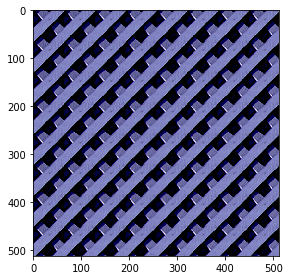

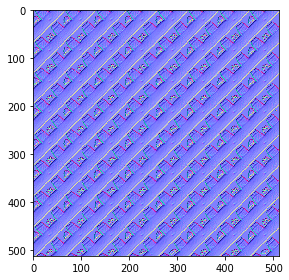

In [8]:
skimage.io.imshow(skimage.img_as_ubyte(color_train_set[0]))
plt.show()
skimage.io.imshow(skimage.img_as_ubyte(normal_train_set[0]))
plt.show()

In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17554190904941194058
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10961242864943448997
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [11]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [12]:
img_size = 512
input_img = Input(shape=(img_size, img_size, 3))

ng = Conv2D(15, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
ng = BatchNormalization()(ng)
ng = AveragePooling2D((4, 4), padding='same')(ng)
ng = Conv2D(30, (3, 3), activation='relu', padding='same', use_bias=False)(ng)
ng = BatchNormalization()(ng)
ng = UpSampling2D((4, 4))(ng)
ng = Conv2D(15, (3, 3), activation='relu', padding='same', use_bias=False)(ng)
ng = BatchNormalization()(ng)
ng = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(ng)
normal_generator = Model(input_img, ng)
normal_generator.compile(Adam(amsgrad=True), loss='mse')

In [13]:
normal_generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 15)      405       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 15)     60        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 15)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 30)      4050      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 30)     120   

In [14]:
normal_generator.fit(color_train_set, normal_train_set,
                     validation_data = (color_test_set, normal_test_set),
                     batch_size=15,
                     epochs=100, workers=10,
                     use_multiprocessing=True)

Epoch 1/100
6/6 [==============================] - 16s 760ms/step - loss: 0.1261 - val_loss: 0.0879
Epoch 2/100
6/6 [==============================] - 1s 254ms/step - loss: 0.1023 - val_loss: 0.0753
Epoch 3/100
6/6 [==============================] - 1s 249ms/step - loss: 0.0896 - val_loss: 0.0693
Epoch 4/100
6/6 [==============================] - 1s 255ms/step - loss: 0.0819 - val_loss: 0.0630
Epoch 5/100
6/6 [==============================] - 1s 251ms/step - loss: 0.0753 - val_loss: 0.0564
Epoch 6/100
6/6 [==============================] - 1s 250ms/step - loss: 0.0702 - val_loss: 0.0500
Epoch 7/100
6/6 [==============================] - 1s 256ms/step - loss: 0.0667 - val_loss: 0.0457
Epoch 8/100
6/6 [==============================] - 1s 250ms/step - loss: 0.0645 - val_loss: 0.0411
Epoch 9/100
6/6 [==============================] - 1s 256ms/step - loss: 0.0607 - val_loss: 0.0363
Epoch 10/100
6/6 [==============================] - 1s 254ms/step - loss: 0.0570 - val_loss: 0.0332
Epoch 11

In [15]:
def test_net_with_random_image():
    idx = int(np.random.rand(1)*len(color_test_set))
    y_legit = skimage.img_as_float(normal_test_set[idx]).reshape(1,img_size,img_size,3)
    y_fake = normal_generator.predict(skimage.img_as_float(color_test_set[idx]).reshape(1,img_size,img_size,3))
    skimage.io.imshow(skimage.img_as_ubyte(y_legit).reshape(img_size,img_size,3))
    plt.show()
    skimage.io.imshow(skimage.img_as_ubyte(y_fake).reshape(img_size,img_size,3))
    plt.show()

1/1 [==============================] - 0s 293ms/step


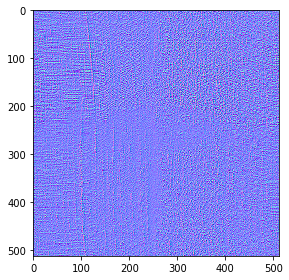

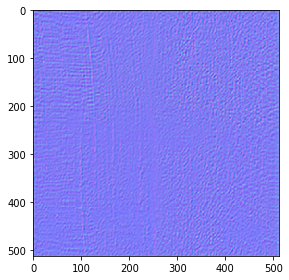

In [16]:
test_net_with_random_image()

In [20]:
normal_generator.save('model.h5')

In [24]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras '/content/model.h5' '/content/model'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-01-10 12:17:20.492052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-10 12:17:20.492206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-01-10 12:17:20.492230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [17]:
!python -m pip install -U imagecodecs[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 95.6 MB/s eta 0:00:00


In [18]:
import imagecodecs
test_img = skimage.io.imread('brick_test.tiff')
skimage.io.imshow(skimage.img_as_ubyte(test_img))
test_img = skimage.img_as_float(test_img)
norm = normal_generator.predict(test_img)
skimage.io.imshow(skimage.img_as_ubyte(norm).reshape(img_size,img_size,3))

FileNotFoundError: ignored